# Flow

![flow](ChatBot.jpg)

## 조사과제: 한국어 정보로 답벗 만들기

### 작업1.정보 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

### 작업2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

### 작업3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

### 작업4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### 작업5. 모델 평가하기
작업1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

### 평가문항
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.  
공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.

2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.  
구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.

3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.  
한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

In [1]:
# !wget https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

In [42]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping , ModelCheckpoint

import seaborn as sns
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
from konlpy.tag import Mecab
from collections import Counter

## 학습데이터 구축
### 작업1.정보 수집하기

데이터를 받아오는 이번 스텝에서 목표로 하는 것은 다음과 같습니다.

1. 질문과 답변의 쌍을 추출한다.
2. 문장에서 단어와 구두점 사이에 공백을 추가한다.
3. 알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.

In [2]:
data_path = './data'
os.listdir(data_path)

['ChatbotData .csv']

In [3]:
df = pd.read_csv(os.path.join(data_path,os.listdir(data_path)[0]))
df # 11823 개의 data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


#### 1.1.데이터 확인

- 영어나 숫자, 중복등이 있는지 확인
- 각 사용된 용례를 확인했을 때 어떤 경우를 삭제해야하는 지 검토
- 결론적으로 대부분 사례가 학습되어야할 것 같아 지우지는 않음

#### 1.1.1 결측치 확인

In [288]:
df.isnull().sum()

Q        0
A        0
label    0
dtype: int64

#### 1.1.2 영어가 포함된 데이터

In [289]:
pattern = r'[a-zA-Z]'
df['q'] = df['Q'].apply(lambda x: len(re.findall(pattern, x))) # 검색되는 경우 알파벳 개수 return
df['a'] = df['A'].apply(lambda x: len(re.findall(pattern, x)))
df['q'].value_counts() #질문에서 알파벳이 검출된 경우가 42회

0    11791
3       19
2        7
1        6
Name: q, dtype: int64

In [290]:
df[df['q']!=0] # 질문에 알파벳 포함

,Q,A,label,q,a
4,PPL 심하네,눈살이 찌푸려지죠.,0,3,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0,2,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0,2,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0,3,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0,3,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0,3,0
10,SNS보면 나만 빼고 다 행복해보여,자랑하는 자리니까요.,0,3,0
754,남친 SNS에 내 사진 없어,신경쓰지 마세요.,0,3,0
762,남친이 SNS에 내 사진에 안 올려,신경쓰지 마세요.,0,3,0
5420,jk김동욱 노래 생각나네,가사가 비슷한가봐요.,1,2,0


In [291]:
df[df['a']!=0] # 대답에 알파벳 포함

,Q,A,label,q,a
1401,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,0,2
2432,서핑하러 가고 싶다,주말에 gogo.,0,0,4
2994,액정 나갔어,as 맡기세요.,0,0,2
4742,컴터 고장났나봐,AS센터에 맡겨보세요.,0,0,2
4744,컴터가 맛이 갔어,AS센터에 맡겨보세요.,0,0,2
4745,컴터가 안돼,AS센터에 맡겨보세요.,0,0,2
5063,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0,0,2
5421,SNS 를 끊어야 하는데.,SNS 끊는게 힘들죠.,1,3,3
5422,SNS 흔적,SNS 흔적 삭제하세요.,1,3,3
5423,sns에서 다른 이성이랑 대화하는걸 보니 화가 나,SNS 보지 마세요.,1,3,3


#### 1.1.3 숫자가 포함된 데이터

In [293]:
pattern = r'[0-9]'
df['q'] = df['Q'].apply(lambda x: len(re.findall(pattern, x))) # 검색되는 경우 숫자 개수 return
df['a'] = df['A'].apply(lambda x: len(re.findall(pattern, x)))
df['q'].value_counts() #질문에서 알파벳이 검출된 경우가 389회

0    11434
1      306
2       71
3       11
4        1
Name: q, dtype: int64

In [294]:
df[df['q']!=0]

,Q,A,label,q,a
0,12시 땡!,하루가 또 가네요.,0,2,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0,1,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,2,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,2,0
176,고3은 공부만 해야겠지.,공부가 최우선이죠.,0,1,0
...,...,...,...,...,...
10750,연애한지 2년째야,딱 좋을 때네요.,2,1,0
10948,자기를 3인칭으로 말하는 여자친구의 말투가 고민임.,귀엽게 봐주세요.,2,1,0
11184,좋아하는 애가 1년만 기다려 달라는데 어쩌지.,기다릴 수 있다면 본인 의지대로 하셔요.,2,1,0
11390,짝남이 내가 좋아하는걸 1도 몰라.,1은 알게 해야죠.,2,1,1


In [295]:
df[df['a']!=0]

,Q,A,label,q,a
67,강렬한 첫인상 남겨야 하는데,처음 3초가 중요해요. 당신의 매력을 어필해보세요.,0,0,1
546,나 정신차리게 말해줘,나 자신에 집중하세요. 언제나 1순위에 자신을 두세요.,0,0,1
1150,단거 땡긴다.,맛있게 먹으면 0칼로리!,0,0,1
1163,달달한 거 먹고 싶다.,맛있게 먹으면 0칼로리!,0,0,1
1356,뒤척이다 늦잠 자게 되네,30분씩 일찍 자는 습관을 들여보세요.,0,0,2
1918,반배정 망했어,1년 힘내요.,0,0,1
1919,반배정부터 올해 끝났다.,1년 힘내요.,0,0,1
3225,연예인 되고 싶어,제가 1호팬 하겠습니다.,0,0,1
3226,연예인 되는 방법,제가 1호팬 하겠습니다.,0,0,1
3482,요즘 잠을 늦게 자,30분씩 일찍 자는 습관을 들여보세요.,0,0,2


#### 1.1.4 중복 데이터

In [5]:
df['A'].nunique() # 대답이 4천개 가량 중복이 있음

7779

In [6]:
df[df['A'].duplicated()]['A'].value_counts() 

맛있게 드세요.              21
제가 있잖아요.              16
조심하세요.                13
감기 조심하세요.             13
잘할 수 있을 거예요.          11
                      ..
더 많이 배웠길 바라요.          1
개인 시간이 생길 거예요.         1
쇼핑은 아울렛이죠.             1
삶의 낙이죠.                1
도피성 결혼은 하지 않길 바라요.     1
Name: A, Length: 2934, dtype: int64

In [7]:
df[df['A']=='맛있게 드세요.'] # 중복을 제거해야하는가? -> 다양한 상황에서도 동일한 대답은 나올 수 있어 No 라고 판단

,Q,A,label
45,간장치킨 시켜야지,맛있게 드세요.,0
49,감 말랭이 먹고 싶다.,맛있게 드세요.,0
50,감 말랭이 먹어야지,맛있게 드세요.,0
1263,도시락 싸가지고 가야지,맛있게 드세요.,0
1267,도시락 싸봐야지,맛있게 드세요.,0
1270,도시락 싸옴,맛있게 드세요.,0
1271,도시락 싸왔어,맛있게 드세요.,0
1390,딸기 먹어야지,맛있게 드세요.,0
1391,딸기 먹을래,맛있게 드세요.,0
1888,바나나 먹고 싶다.,맛있게 드세요.,0


In [8]:
df[df['Q'].duplicated()].value_counts('Q')

Q             
외로워               3
사랑을 했다            2
올해 왜 이러지          2
너무 힘들다            2
2년 가량의 연애         1
                 ..
배불러               1
봄 타나 봄.           1
불타올랐다가 식었어        1
비 오는데?            1
훔쳐보는 것도 눈치 보임.    1
Length: 156, dtype: int64

In [9]:
df[df['Q']=='외로워'] # 같은 질문에 다양한 답을 할 수 있음 

,Q,A,label
3456,외로워,친구를 사귀어 보세요.,0
3457,외로워,혼자가 아니에요.,0
7261,외로워,제가 곁에 있을게요.,1
7262,외로워,혼자가 아니에요.,1


In [10]:
df[df.duplicated(['Q','A'])]['Q'].value_counts() # Q,A 전부 중복되는 경우를 검색

결혼이나 하지 왜 자꾸 나한테 화 내냐구!    1
야                          1
중2 히스테리 알아?                1
주차장이 꽉 찼어                  1
저 사람이 왜 자꾸 볼까?             1
                          ..
뻔하다                        1
비밀번호 뭐였더라                  1
뭔가 무섭다                     1
문 잠겼는데 집에 아무도 없네           1
내일 만나자고 해볼까?               1
Name: Q, Length: 73, dtype: int64

In [11]:
df[df['Q']=='야'] # q,a 중복만 제거

,Q,A,label
2995,야,네,0
6909,야,네,1


In [12]:
df[df['Q']=='뻔하다'] # q,a 중복만 제거

,Q,A,label
2251,뻔하다,한가지만 보면 몰라요.,0
6561,뻔하다,한가지만 보면 몰라요.,1


In [296]:
df = df.drop_duplicates(['Q','A'])
df.shape # 73개 제거

(11750, 5)

### 작업2. 데이터 전처리하기
#### 구두점 분리 및 이상 특문, 영어, 숫자 제거

?나 .과 같은 구두점들이 단어들과 분리되어 단어와 구두점 사이에는 공백이 추가  
단어를 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지

In [297]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 특이 특수 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣.?!,]",' ', sentence)
    sentence = sentence.strip()
    return sentence

In [298]:
#질문을 questions, 답변을 answers에 저장합니다.
questions, answers = [preprocess_sentence(q) for q in df['Q'].tolist()], [preprocess_sentence(a) for a in df["A"].tolist()]
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11750
전체 샘플 수 : 11750


In [304]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[40]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[40]))

전처리 후의 22번째 질문 샘플: 간만에 떨리니까 좋더라
전처리 후의 22번째 답변 샘플: 떨리는 감정은 그 자체로 소중해요 .


### 작업3. SubwordTextEncoder 사용하기

1. TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩 한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

### Vocabulary

In [300]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [301]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [302]:
print('START_TOKEN의 번호 :' ,START_TOKEN)
print('END_TOKEN의 번호 :' ,END_TOKEN)

START_TOKEN의 번호 : [8132]
END_TOKEN의 번호 : [8133]


In [303]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8134


In [305]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[50])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[50])))

정수 인코딩 후의 21번째 질문 샘플: [3154, 306, 8111, 8034, 8049, 11, 672]
정수 인코딩 후의 21번째 답변 샘플: [499, 124, 1]


In [306]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[40]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [7834, 1718, 330, 4872]
기존 문장: 간만에 떨리니까 좋더라


In [307]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

7834 ----> 간만에 
1718 ----> 떨리
330 ----> 니까 
4872 ----> 좋더라


In [308]:
data = questions + answers

In [309]:
print('[Data Report]')
print()
max_len = max(len(l) for l in data)
print('-- 질의응답의 최대 길이 : %d' % max_len)
print('-- 질의응답의 최소 길이 : %d' % min(len(l) for l in data))
print('-- 질의응답의 평균 길이 : %f' % (sum(map(len, data))/len(data)))
print('-- 질의응답의 중간 길이 : %f' % (np.median(list(map(len, data)))))
print('-- 질의응답의 표준 편차 : %f' % (np.std(list(map(len, data)))))
print()

[Data Report]

-- 질의응답의 최대 길이 : 78
-- 질의응답의 최소 길이 : 1
-- 질의응답의 평균 길이 : 14.639574
-- 질의응답의 중간 길이 : 13.000000
-- 질의응답의 표준 편차 : 6.742508



In [310]:
MAX_LENGTH = 11
"data covered by length %s : %.2f percentage"%(MAX_LENGTH, sum([len(x)<=MAX_LENGTH for x in data])*100/len(data))

'data covered by length 11 : 36.40 percentage'

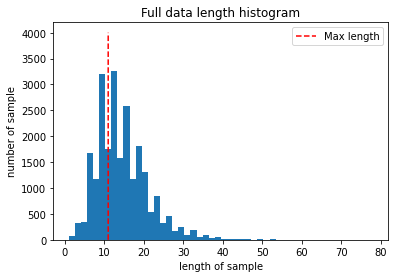

In [311]:
plt.hist([len(s) for s in data], bins=50)
plt.plot([MAX_LENGTH]*4000,range(4000), 'r--', label = 'Max length')
plt.title('Full data length histogram')
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.legend()
plt.show()

In [312]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs,
                                                                     maxlen=MAX_LENGTH,
                                                                     padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs,
                                                                      maxlen=MAX_LENGTH,
                                                                      padding='post')

    return tokenized_inputs, tokenized_outputs

In [313]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8134
필터링 후의 질문 샘플 개수: 10035
필터링 후의 답변 샘플 개수: 10035


In [314]:
# 0번 샘플을 임의로 출력
print(questions[40])
print(answers[40])

[8132  624  367  416 5994 5151   47 8133    0    0    0]
[8132  499  124    1 8133    0    0    0    0    0    0]


### 작업4. 모델 구성하기

#### 4.1 Data 모듈을 이용한 데이터 구상

In [315]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 포지션과 i 값을 사용하여 각도 계산
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩을 생성하는 함수
        # position: 입력으로 받은 문장의 최대 길이
        # d_model: 임베딩된 단어의 차원 수 (모델의 hidden size)

        # 각 위치별로 각도 계산
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수를 적용하여 각도 값 계산
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cosine 함수를 적용하여 각도 값 계산
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin 함수와 cosine 함수의 값들을 교차하며 재배열하여 포지셔널 인코딩 생성
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        # pos_encoding에 차원을 추가하여 3차원 텐서로 만듭니다. (배치 크기를 포함한 3차원)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        # 입력 임베딩 텐서와 포지셔널 인코딩 텐서를 더하여 위치 정보를 추가합니다.
        # 입력과 포지셔널 인코딩은 크기가 같아야 합니다.
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


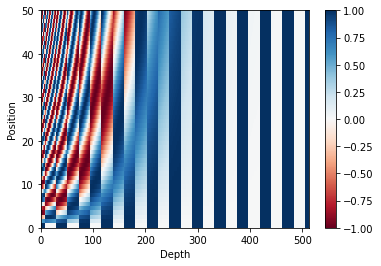

In [316]:
# sample_pos_encoding = np.random.randint(5, size=(50, 512))
sample_pos_encoding =  PositionalEncoding(50,512)


plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### 4.2 필요 Layer class 선언
- scaled_dot_product_attention : attention 연산
- MultiHeadAttention : input 차원을 n_heads로 나누어 예산
- create_padding_mask : 데이터 padding
- create_look_ahead_mask : 유사도 matrix에서 key axis의 값들을 가려 query 부분에 집중시킴

### self attention

다른 문장의 단어가 아니 `현재 문장 내`의 단어들이 서로 유사도를 구하는 경우

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_13_hjMyZwL.png)

위 그림은 self-attnetion 계산을 통하여 it과 animal과 높은 상관관계를 가지고 있다는 것을 도출한 예시를 표현

출처 : [구글ai블로그포스팅](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)

In [317]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


#### multi-head attention

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_19_FwmaA3q.png)

차원을 head 개수로 나누어 그만큼 다양한 관점으로 보겠다의 의미
(e.g.Convolution filter 개수)

In [318]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs,
                            shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

#### masking

![](https://d3s0tskafalll9.cloudfront.net/media/images/1365906-20200410103623697-871078599.max-800x600.png)

설정 길이만큼 자르고 채움

#### look ahead mask

한번에 문장을 입력받는 transformer의 경우 모든 문장을 보고 문장을 생성할 수 있어,  
cheating을 방지하는 목적으로 수행

![](https://d3s0tskafalll9.cloudfront.net/media/images/_.max-800x600.png)

In [319]:
def create_padding_mask(x):
    """
    패딩 마스크를 생성하는 함수입니다.

    Args:
      x: 입력 시퀀스 텐서. 정수로 구성된 텐서로서, 0은 패딩 값을 나타냅니다.
         (예: [2, 4, 6, 0, 0]는 패딩이 적용된 길이가 5인 시퀀스입니다.)

    Returns:
      mask: 패딩 마스크. 패딩 위치에 1을 표시하는 텐서입니다. (pad 위치: True, 그 외: False)
            3차원 텐서로서, (batch_size, 1, 1, sequence_length)의 크기를 가집니다.
            이 마스크는 트랜스포머에서 패딩된 부분을 무시하는 데 사용됩니다.
    """

    # x에서 값이 0인 위치를 찾아서 True로, 그 외 위치를 False로 변환합니다.
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)

    # 차원을 늘려서 마스크를 (batch_size, 1, 1, sequence_length) 크기로 변환합니다.
    # 이렇게 하면 브로드캐스팅을 이용하여 패딩 마스크를 인코더 및 디코더에서 사용할 수 있게 됩니다.
    mask = mask[:, tf.newaxis, tf.newaxis, :]

    return mask

In [320]:
#예시

print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [321]:
def create_look_ahead_mask(x):
    """
    미래의 단어를 가리는(look-ahead) 마스크와 패딩 마스크를 결합하여 어텐션 마스크를 생성하는 함수입니다.

    Args:
      x: 입력 시퀀스 텐서. 정수로 구성된 텐서로서, 0은 패딩 값을 나타냅니다.
         (예: [2, 4, 6, 0, 0]는 패딩이 적용된 길이가 5인 시퀀스입니다.)

    Returns:
      어텐션 마스크: 패딩 마스크와 미래 단어를 가리는 마스크를 결합한 결과입니다.
                    트랜스포머의 디코더 부분에서 사용됩니다.
    """

    # 입력 시퀀스의 길이를 가져옵니다.
    seq_len = tf.shape(x)[1]

    # 미래 단어를 가리는 마스크를 생성합니다.
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

    # 패딩 마스크를 생성합니다. create_padding_mask 함수는 이전에 정의되어 있습니다.
    padding_mask = create_padding_mask(x)

    # 미래 단어를 가리는 마스크와 패딩 마스크를 결합합니다.
    # tf.maximum 함수를 사용하여 어텐션 마스크를 생성합니다.
    # tf.maximum 함수는 두 마스크 중에서 큰 값을 선택하는 역할을 합니다.
    # 따라서 미래 단어가 있는 부분은 look_ahead_mask를 따르고, 패딩된 부분은 padding_mask를 따릅니다.
    # 이렇게 어텐션 마스크를 생성하면 트랜스포머의 디코더에서 미래 단어와 패딩된 부분을 올바르게 처리할 수 있습니다.
    attention_mask = tf.maximum(look_ahead_mask, padding_mask)

    return attention_mask

In [322]:
# 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야함
# 만약 입력 시퀀스에 0과 같은 패딩 값을 가진 단어가 있다면, 이 단어들은 패딩된 부분이므로 어텐션 계산에 영향을 주지 않도록 패딩 마스크를 반드시 추가

print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


#### 4.2 Build Transformer

- encoder (with encoder_layer)
- decoder (with decoder_layer)

- transfomer (Mask_layers + encoder + eecoder)

#### Encoder

구조
1. Self-Attention  
2. Feed Forward Neural Network

![Encoder](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_22_teJgoCi.max-800x600.png)

근데 self-attention은 multi-head를 통해 병렬적 진행

이 layer들을 원하는 만큼 연결하여 값을 이해하고 decoder로 전달

In [323]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # ===========첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션===========
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # ===========두 번째 서브 레이어 : 2개의 완전연결층 ===========
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [324]:
# 위의 encoder_layer 함수를 이용하여 원하는 만큼 적재
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### Decoder

Encoder와 비교하면 한가지 module이 추가됨

![https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_24_Kj9egLY.max-800x600.png](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_24_Kj9egLY.max-800x600.png)


1. Self-Attention  
2. `Encoder-Decoder Attention  `
3. Feed Forward Neural Network

이 또한 원하는 만큼 쌓아서 만들 수 있으나
많으면 많을 수록 학습소요시간이 몹시 길어짐

#### Encoder-Decoder Attention ?

인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정  

 `Query가 디코더의 벡터`인 반면에 `Key와 Value가 인코더의 벡터`
 
디코더가 하나의 출력 단어를 생성할 때  
소스 문장에서 나왔던 인코더의 모든 출력 값 중 어떤 값과 가장 연관성이 있는지 구하기 위해 수치화하는 layer 구간
[ref](https://nongnongai.tistory.com/62?category=924000)

In [325]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # ===========첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)===========
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # ===========두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)===========
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, # 첫번째 sublayer에서 진행한 결과 
          'key': enc_outputs, # encoder 꺼
          'value': enc_outputs,# encoder 꺼
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # ===========세 번째 서브 레이어 : 2개의 완전연결층===========
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,
                          name=name)

In [326]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                        outputs=outputs,
                        name=name)

#### 4.3 Build & Train Model

In [327]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    #=================================Encoder =================================
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    #=================================Decoder =================================
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask]) 
    # dataset에서 question에 대한 answer를 decoder에 input을 넣음 (encoder 값이 아니라 실제 데이터를 넣어 Teacher forcing 진행)

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [328]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 2 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 128 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 128)    1240320     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [329]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


##### Custom Learning rate

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.

$$learning\_rate = d^{-0.5}_{model} \cdot \min(\text{step_num}^{-0.5}, \text{step_num} \cdot \text{warmup_steps}^{-1.5})$$

아직 잘 모름

In [330]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [331]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [332]:
BATCH_SIZE = 32
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [333]:
es = EarlyStopping(
    monitor='loss', 
    min_delta = 0.0005,
    mode = 'auto',
    patience=2, 
    verbose=1)

In [334]:
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks = es)

Epoch 1/100
314/314 [==============================] - 15s 26ms/step - loss: 5.1349 - accuracy: 0.1168
Epoch 2/100
314/314 [==============================] - 8s 26ms/step - loss: 3.8153 - accuracy: 0.1938
Epoch 3/100
314/314 [==============================] - 8s 27ms/step - loss: 3.2615 - accuracy: 0.2013
Epoch 4/100
314/314 [==============================] - 9s 27ms/step - loss: 3.0088 - accuracy: 0.2177
Epoch 5/100
314/314 [==============================] - 9s 27ms/step - loss: 2.7740 - accuracy: 0.2341
Epoch 6/100
314/314 [==============================] - 8s 27ms/step - loss: 2.5147 - accuracy: 0.2585
Epoch 7/100
314/314 [==============================] - 9s 27ms/step - loss: 2.2331 - accuracy: 0.2887
Epoch 8/100
314/314 [==============================] - 9s 27ms/step - loss: 1.9368 - accuracy: 0.3213
Epoch 9/100
314/314 [==============================] - 8s 27ms/step - loss: 1.6376 - accuracy: 0.3541
Epoch 10/100
314/314 [==============================] - 9s 28ms/step - loss: 1.36

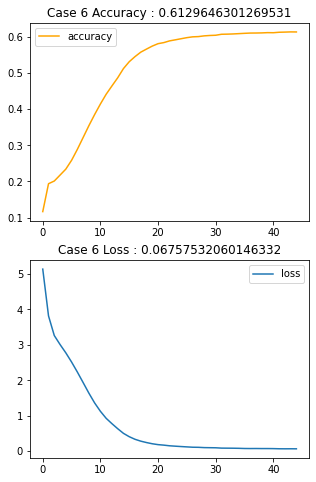

===========================Case 6===========================

[단순 일상 #1]
입력 : 배가 고팠어.
출력 : 뭐 좀 챙겨드세요 .
[단순 일상 #2]
입력 : 과식을 했어.
출력 : 소화제 드세요 .
[복합 일상]
입력 : 배가 고팠어서 과식을 했어.
출력 : 사랑의 예의가 없네요 .
[영어 복합 #1]
입력 : sns에서 보고 샀어.
출력 : 득템 했네요 .
[영어 복합 #2]
입력 : cf에서 보고 샀어.
출력 : 후회할 것 같다면 늦지 않게 연락해보세요 .
[숫자 복합 #1]
입력 : 1도 모르겠다.
출력 : 있는   진정하세요 .
[숫자 복합 #2]
입력 : 새가 10마리 보다 많았어.
출력 : 잘 해결되길 바라요 .
[띄어쓰기 #1]
입력 : 아버지가 방에 들어가신다.
출력 : 오늘도 이렇게 이겨냈어요 .
[띄어쓰기 #2]
입력 : 아버지 가방에 들어가신다.
출력 : 오늘도 이렇게 이겨냈어요 .
[뜬금 영어 #1]
입력 : how have you been?
출력 : 사람 마음은 알다가도 모르니까 그럴 수도 있어요 .
[뜬금 영어 #2]
입력 : Thank you!
출력 : 좋아하는 사람이 있는 장소에 가보세요 .


In [335]:
show_log(history, 'Case 6')
qna(model, 'Case 6')  # 단순한 한글 질문에는 꽤 괜찮게 대답하지만....

### 작업5. 모델 평가하기

- 여러 hyperparameter 비교
- 같은 질문에 대한 여러 가지 모델의 대답 비교 

In [45]:
def decoder_inference(sentence):
    
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [46]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [53]:
def show_log(history, case):
    fig, ax = plt.subplots(2,1, figsize = (5, 8))
    ax[0].set_title(f"{case} Accuracy : {history.history['accuracy'][-1]}")
    ax[0].plot(range(len(history.history['accuracy'])), history.history['accuracy'], 'orange', label = 'accuracy')
    # ax[0].set_ylim([0,0.5])
    ax[0].legend()
    ax[1].set_title(f"{case} Loss : {history.history['loss'][-1]}")
    ax[1].plot(range(len(history.history['accuracy'])), history.history['loss'], label = 'loss')
    ax[1].legend()
    plt.show()

In [172]:
def qna(model, case): # 여러 case에서 어떻게 대답하는 지 확인
    print(f"==========================={case}===========================")
    print()
    print("[단순 일상 #1]")
    sentence_generation('배가 고팠어.') # 일상1
    print("[단순 일상 #2]")
    sentence_generation('과식을 했어.') # 일상 2
    print("[복합 일상]")
    sentence_generation('배가 고팠어서 과식을 했어.') # 복합의미
    print("[영어 복합 #1]")
    sentence_generation('sns에서 보고 샀어.') # 영어 복합
    print("[영어 복합 #2]")
    sentence_generation('cf에서 보고 샀어.') # 영어 복합 2
    print("[숫자 복합 #1]")
    sentence_generation('1도 모르겠다.') # 숫자 복합 
    print("[숫자 복합 #2]")
    sentence_generation('새가 10마리 보다 많았어.') # 숫자 복합2
    print("[띄어쓰기 #1]")
    sentence_generation('아버지가 방에 들어가신다.') # 띄어쓰기
    print("[띄어쓰기 #2]")
    sentence_generation('아버지 가방에 들어가신다.') # 띄어쓰기2
    print("[뜬금 영어 #1]")
    sentence_generation('how have you been?')
    print("[뜬금 영어 #2]")
    sentence_generation('Thank you!')

```python
def Baseline(
        Batch = 64,
        MAX_LENGTH = 40,
        D_MODEL = 256,
        NUM_LAYERS = 2,
        NUM_HEADS = 8,
        UNIS = 512,
        DROPOUT = 0.1
)
```
- Baseline : Baseline
- case 1 : Baseline(Batch = 32, MAX_LENGTH = 11, D_MODEL = 512)
- case 2 : Baseline(Batch = 32, MAX_LENGTH = 11, D_MODEL = 512, NUM_HEADS = 16)
- **case 3 [BEST]** : Baseline(Batch = 32, `MAX_LENGTH = 10`, D_MODEL = 512, NUM_HEADS = 16, NUM_LAYERS = 4, UNIS = 1024) 
- case 4 : Baseline(Batch = 32, `MAX_LENGTH = 25`, D_MODEL = 512, NUM_HEADS = 16, NUM_LAYERS = 4, UNIS = 1024)
- case 5 : Baseline(Batch = 32, `MAX_LENGTH = 40`, D_MODEL = 512, NUM_HEADS = 16, NUM_LAYERS = 4, UNIS = 1024)

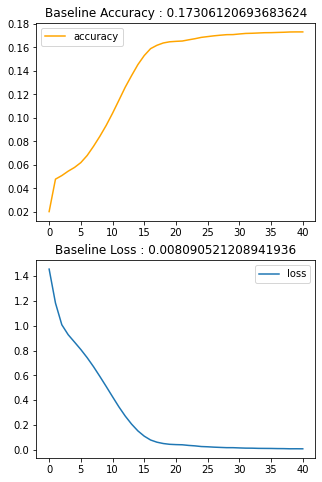

===========================Baseline===========================

[단순 일상 #1]
입력 : 배가 고팠어.
출력 : 뭐 좀 챙겨드세요 .
[단순 일상 #2]
입력 : 과식을 했어.
출력 : 소화제 챙겨드세요 .
[복합 일상]
입력 : 배가 고팠어서 과식을 했어.
출력 : 내일은 좀 더 나은 하루일 거예요 .
[영어 복합 #1]
입력 : sns에서 보고 샀어.
출력 : 개인 성향 차이인 것 같아요 .
[영어 복합 #2]
입력 : cf에서 보고 샀어.
출력 : 운동 해보세요 .
[숫자 복합 #1]
입력 : 1도 모르겠다.
출력 : 지도 어플을 실행해보세요 .
[숫자 복합 #2]
입력 : 새가 10마리 보다 많았어.
출력 : 잘 해결되길 바라요 .
[띄어쓰기 #1]
입력 : 아버지가 방에 들어가신다.
출력 : 도전해 봐도 좋을 거 같아요 .
[띄어쓰기 #2]
입력 : 아버지 가방에 들어가신다.
출력 : 전역해서 더 좋은 사람 만날 수 있을 거예요 .
[뜬금 영어 #1]
입력 : how have you been?
출력 : 더 좋은 사람 만나실 거예요 .
[뜬금 영어 #2]
입력 : Thank you!
출력 : 고민하고 있다면 그게 맞을거예요 .


In [210]:
# Baseline(Batch = 64,MAX_LENGTH = 40,D_MODEL = 256,NUM_LAYERS = 2,NUM_HEADS = 8,UNITS = 512,DROPOUT = 0.1)
show_log(history, 'Baseline')
qna(model, 'Baseline')  # 단순한 한글 질문에는 꽤 괜찮게 대답하지만....

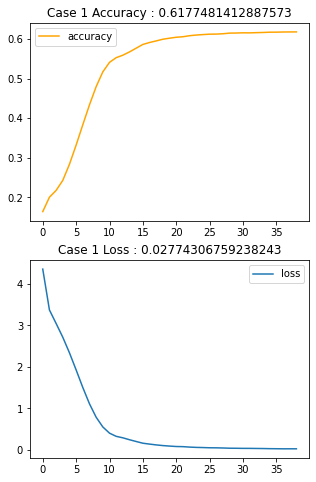

===========================Case 1===========================

[단순 일상 #1]
입력 : 배가 고팠어.
출력 : 저도 밥 먹고 싶어요
[단순 일상 #2]
입력 : 과식을 했어.
출력 : 소화제 드세요 .
[복합 일상]
입력 : 배가 고팠어서 과식을 했어.
출력 : 날씨에 따라 감정도 변하죠 .
[영어 복합 #1]
입력 : sns에서 보고 샀어.
출력 : 개인 성향 차이인 것 같아요 .
[영어 복합 #2]
입력 : cf에서 보고 샀어.
출력 : 이젠 마음의 결정을 내릴 때에요 .
[숫자 복합 #1]
입력 : 1도 모르겠다.
출력 : 아직은 실감이 나지 않을 거예요 .
[숫자 복합 #2]
입력 : 새가 10마리 보다 많았어.
출력 : 잘 해결되길 바라요 .
[띄어쓰기 #1]
입력 : 아버지가 방에 들어가신다.
출력 : 오늘도 해내고 해낸겁니다 .
[띄어쓰기 #2]
입력 : 아버지 가방에 들어가신다.
출력 : 자신을 조금 더 사랑해보세요 .


In [128]:
# case 1 : Baseline(Batch = 32, MAX_LENGTH = 11, D_MODEL = 512)
show_log(history, 'Case 1')
qna(model, 'Case 1')  # 여전히 복합적인 글이나 영어 숫자가 들어가면 대답이 이상해짐

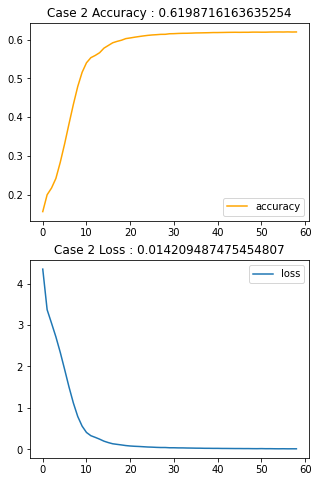

===========================Case 2===========================

[단순 일상 #1]
입력 : 배가 고팠어.
출력 : 뭐 좀 챙겨드세요 .
[단순 일상 #2]
입력 : 과식을 했어.
출력 : 소화제 드세요 .
[복합 일상]
입력 : 배가 고팠어서 과식을 했어.
출력 : 좀 괜찮은가요 .
[영어 복합 #1]
입력 : sns에서 보고 샀어.
출력 : 내 집 마련 축하드려요 .
[영어 복합 #2]
입력 : cf에서 보고 샀어.
출력 : 득템 했네요 .
[숫자 복합 #1]
입력 : 1도 모르겠다.
출력 : 지도 어플을 실행해보세요 .
[숫자 복합 #2]
입력 : 새가 10마리 보다 많았어.
출력 : 잘 해결되길 바라요 .
[띄어쓰기 #1]
입력 : 아버지가 방에 들어가신다.
출력 : 내일은 나을 거예요 .
[띄어쓰기 #2]
입력 : 아버지 가방에 들어가신다.
출력 : 사랑한 만큼 아픔이 오죠 .


In [55]:
# case 2 : Baseline(Batch = 32, MAX_LENGTH = 11, D_MODEL = 512, NUM_HEADS = 16)
show_log(history, 'Case 2')
qna(model, 'Case 2') # 성능이 나아지진 않았지만 좀 더 대답이 자연스러운 것 같음

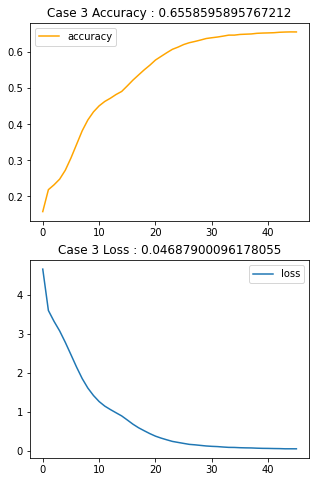

===========================Case 3===========================

[단순 일상 #1]
입력 : 배가 고팠어.
출력 : 많이 괜찮아지고 있어요 .
[단순 일상 #2]
입력 : 과식을 했어.
출력 : 소화제 챙겨드세요 .
[복합 일상]
입력 : 배가 고팠어서 과식을 했어.
출력 : 마음이 복잡한가봐요 .
[영어 복합 #1]
입력 : sns에서 보고 샀어.
출력 : 제가 곁에 있을게요 .
[영어 복합 #2]
입력 : cf에서 보고 샀어.
출력 : 많은 생각이 들었나봐요 .
[숫자 복합 #1]
입력 : 1도 모르겠다.
출력 : 그럼에도 마음이 정리가 안되나봐요 .
[숫자 복합 #2]
입력 : 새가 10마리 보다 많았어.
출력 : 생각을 자주하면 나올 수 있어요 .
[띄어쓰기 #1]
입력 : 아버지가 방에 들어가신다.
출력 : 공부를 많이 해놨나봐요 .
[띄어쓰기 #2]
입력 : 아버지 가방에 들어가신다.
출력 : 새로운 시작 응원해요 !
[뜬금 영어 #1]
입력 : how have you been?
출력 : 알고 있을 거예요 .
[뜬금 영어 #2]
입력 : Thank you!
출력 : 놀 때 놀고 할 때 하세요 .


In [173]:
# Case 3: Baseline(Batch = 32, `MAX_LENGTH = 10`, D_MODEL = 512, NUM_HEADS = 16, NUM_LAYERS = 4, UNIS = 1024) 
show_log(history, 'Case 3')
qna(model, 'Case 3') # 나름 성능은 제일 괜찮았는데 대답이 제일 좋았냐 라는 부분에는 흠

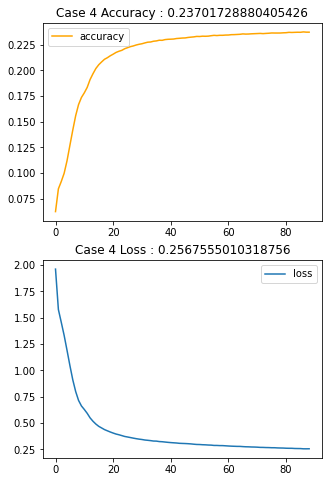

===========================Case 4===========================

[단순 일상 #1]
입력 : 배가 고팠어.
출력 : 많이 힘들텐데 저에게 말해보세요 .
[단순 일상 #2]
입력 : 과식을 했어.
출력 : 휴가를 붙여보세요 .
[복합 일상]
입력 : 배가 고팠어서 과식을 했어.
출력 : 많이 피곤한가봐요 .
[영어 복합 #1]
입력 : sns에서 보고 샀어.
출력 : 아무 생각 하지 말고 쉬세요 .
[영어 복합 #2]
입력 : cf에서 보고 샀어.
출력 : 이제 내려올 때가 됐어요 .
[숫자 복합 #1]
입력 : 1도 모르겠다.
출력 : 그럴 때가 있죠 . 정신 차리세요 .
[숫자 복합 #2]
입력 : 새가 10마리 보다 많았어.
출력 : 다른 인연이 ㅊ자아올 거예요 .
[띄어쓰기 #1]
입력 : 아버지가 방에 들어가신다.
출력 : 고민하고 있다면 그게 맞을거예요 .
[띄어쓰기 #2]
입력 : 아버지 가방에 들어가신다.
출력 : 없는 것보다 나을 거예요 .
[뜬금 영어 #1]
입력 : how have you been?
출력 : 그 이유를 찾는 과정이 되겠네요 .
[뜬금 영어 #2]
입력 : Thank you!
출력 : 슬프네요 .


In [248]:
# case 4 : Baseline(Batch = 32, `MAX_LENGTH = 25`, D_MODEL = 512, NUM_HEADS = 16, NUM_LAYERS = 4, UNIS = 1024)
show_log(history, 'Case 4')
qna(model, 'Case 4') # 대답은 길어졌는데 맥락파악이 안된 느낌

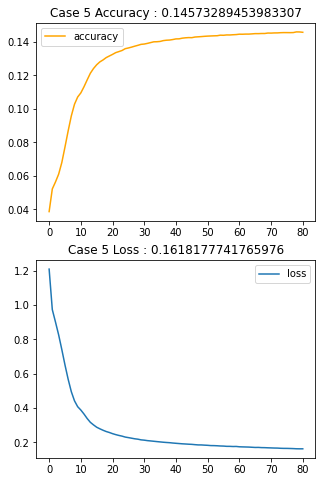

===========================Case 5===========================

[단순 일상 #1]
입력 : 배가 고팠어.
출력 : 제가 있잖아요 .
[단순 일상 #2]
입력 : 과식을 했어.
출력 : 잘 하고 있어요 .
[복합 일상]
입력 : 배가 고팠어서 과식을 했어.
출력 : 이제 더 잘 될 일만 남았네요 .
[영어 복합 #1]
입력 : sns에서 보고 샀어.
출력 : 내가 맞는 것과 맞지 않은 걸 구별해보세요 .
[영어 복합 #2]
입력 : cf에서 보고 샀어.
출력 : 다른 생각을 해보세요 .
[숫자 복합 #1]
입력 : 1도 모르겠다.
출력 : 다른 곳에 쓰려고 운을 아껴뒀나봐요 .
[숫자 복합 #2]
입력 : 새가 10마리 보다 많았어.
출력 : 긴 시간이었던 만큼 쉽지 않았을거라 생각해요 .
[띄어쓰기 #1]
입력 : 아버지가 방에 들어가신다.
출력 : 잠시 휴식을 취해보세요 .
[띄어쓰기 #2]
입력 : 아버지 가방에 들어가신다.
출력 : 너무 신경 곤두세우지 마세요 .
[뜬금 영어 #1]
입력 : how have you been?
출력 : 내가 맞는 것과 맞지 않은 걸 구별해보세요 .
[뜬금 영어 #2]
입력 : Thank you!
출력 : 다른 연락을 많이 하거나 더 자주 만나세요 .


In [286]:
# case 5 : Baseline(Batch = 32, `MAX_LENGTH = 40`, D_MODEL = 512, NUM_HEADS = 16, NUM_LAYERS = 4, UNIS = 1024)
show_log(history, 'Case 5')
qna(model, 'Case 5') # 문장 생성은 길고 자연스럽게 잘하지만 질문에 대한 맥락 파악을 못함

## 회고

- 직접 모델을 구축하는 건 아니어서 코드 진행 상 어렵지는 않았지만 내용이 어려웠음
- 데이터에 대한 중복처리를 안하는 것이 다양한 case에 대해 학습시킬 수 있을 것이라 생각하여 진행하지 않았음  
    : 중복처리를 하게 되었을 때의 accuracy/loss 양상 비교를 추가로 실험할 수 있는 주제라 생각
- hyperparameter의 조정보다는 입출력데이터의 길이를 조절(MAX_LENGTH)하는 것이 성능에 큰 영향을 주는 것을 확인
- Accuracy 가 문장 생성 능력에 대해 직접 대변하지는 못하는 것 같음  
(chatbot에 대한 metrics 가 있는가?에 대해서 검색 결과가 잘 나오진 않음 )

- 존댓말이나 MBTI 별 대답 등의 특이적인 데이터셋이 있으면 재밌는 결과가 나올 수 있을 것 같음



- problem

```
입력 : 배가 너무 불러
출력 : 좀

입력 : 배가 너무 불러
출력 : 좀

```
말을 하다 만다..
epoch 100 도 동일함 : 약 90 epoch에서 0.0022 대 유지하며 진행되는 경향을 보여 loss 는 충분히 떨어진 것으로 보임=> 문제?
```
#decoder_inference

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
```

indent 정리하다 해당 부분이 for문 밖에 나와있었음. concat 되지 못해서 문장을 이어갈 수 가 없던 것

대답이 너무 이상하면 관련 코드를 살펴보는 것도 방법 중에 하나가 될 수 있을...듯?